## Imports

In [46]:
import os
import matplotlib.pyplot as plt
from matplotlib.image import imread
import pandas as pd
from PIL import Image

import tensorflow as tf
import numpy as np
from tensorflow.keras import layers

## EDA (Exploratory Data Analysis)

In [47]:
# Set the directory path where the images are located
directory_path = os.environ['DATASET_PATH']

# Get a list of all the image files in the directory
image_files = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if f.endswith('.jpg')]

# Sort the list of image files by name (optional)
image_files.sort()

# Create a subplot grid with 4 rows and 5 columns
fig, axs = plt.subplots(nrows=4, ncols=5, figsize=(10, 8))

# Loop through the first 20 images and display them in the subplot grid
for i in range(20):
    if i >= len(image_files):
        break
    img = imread(image_files[i])
    row = i // 5
    col = i % 5
    axs[row, col].imshow(img)
    axs[row, col].axis('off')

# Display the subplot grid
plt.show()


KeyboardInterrupt: 

In [ ]:
print ('Number of images:', len(image_files))

Number of images: 202599


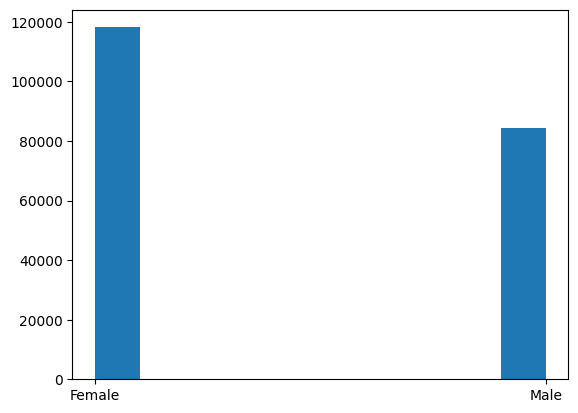

In [ ]:
path = os.environ['CSVPATH']

# Load data from CSV file
df = pd.read_csv(path)

classes = {-1: 'Female', 1: 'Male'}

plt.hist(list(map(lambda x: classes[x] , df['Male'])))
plt.show()

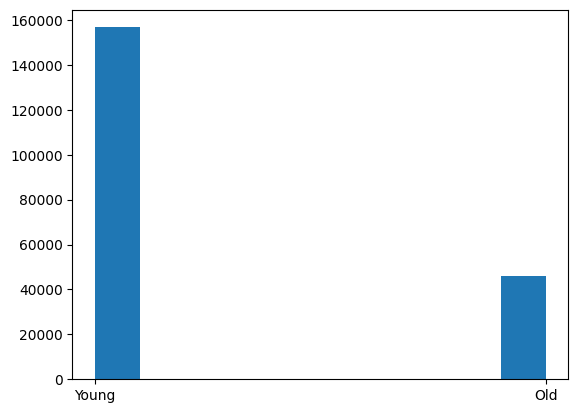

In [ ]:
classes = {-1: 'Old', 1: 'Young'}

plt.hist(list(map(lambda x: classes[x] , df['Young'])))
plt.show()

## Hyperparameters

In [ ]:
EPOCHS = 1500
NOISE_DIM = 250
BATCH_SIZE = 64

MAX_SIZE = len(image_files)
RANDOM_SELECT = 0.1

INITIAL_TRAIN_RATIO = 5
INITIAL_EPOCHS = 20
TRAIN_DECAY = 0.8
TRAIN_DECAY_EPOCHS = 10

INTERVAL = 5

## Models

### Discriminator

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(128, 128, 3,)),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])

    return model

In [ ]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        4864      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 64, 64, 64)        0         
                                                                 
 dropout_2 (Dropout)         (None, 64, 64, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 128)       204928    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 dropout_3 (Dropout)         (None, 32, 32, 128)       0         
                                                                 
 flatten_1 (Flatten)         (None, 131072)           

### Generator

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential([
        layers.Dense(32*32*512, use_bias=False, input_shape=(NOISE_DIM,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Reshape((32, 32, 512)),
        layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh')
    ])

    return model

In [ ]:
generator = make_generator_model()
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 524288)            131072000 
                                                                 
 batch_normalization (BatchN  (None, 524288)           2097152   
 ormalization)                                                   
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 524288)            0         
                                                                 
 reshape (Reshape)           (None, 32, 32, 512)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 256)      3276800   
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 256)     

## Loss Functions and Optimizers

In [ ]:
optimizer = tf.keras.optimizers.Adam(1e-4)
loss_object = tf.keras.losses.BinaryCrossentropy()

### Continute Training

In [ ]:
TRAINING_RESUME = True
epoch = 1330

if(TRAINING_RESUME):
    # generator = tf.keras.models.load_model(os.path.join(os.environ['CHECKPOINT_PATH'], f"generator_epoch_{epoch}.h5"))
    # discriminator = tf.keras.models.load_model(os.path.join(os.environ['CHECKPOINT_PATH'], f"discriminator_epoch_{epoch}.h5"))
    generator.load_weights(os.path.join(os.environ['CHECKPOINT_PATH'], f"generator_epoch_{epoch}.h5"))
    discriminator.load_weights(os.path.join(os.environ['CHECKPOINT_PATH'], f"discriminator_epoch_{epoch}.h5"))

In [ ]:
## Discriminator setup
discriminator.compile(optimizer=optimizer, loss=loss_object, metrics=['accuracy'])
discriminator.trainable = False

In [ ]:
## Generator setup
noise = layers.Input(shape=(NOISE_DIM,))
image = generator(noise)

## Combined model
validity = discriminator(image)
combined = tf.keras.Model(noise, validity)
combined.compile(optimizer=optimizer, loss=loss_object)

## Utility Functions

In [ ]:
def discriminator_train(epoch):
    if epoch < INITIAL_EPOCHS:
        ratio = INITIAL_TRAIN_RATIO
    
    else:
        ratio = max(1,INITIAL_TRAIN_RATIO * TRAIN_DECAY ** ((epoch - INITIAL_EPOCHS) // TRAIN_DECAY_EPOCHS))
    
    return (epoch%ratio == 0)


In [ ]:
def sample_image(epoch):
    noise = np.random.normal(0, 1, (1, NOISE_DIM))

    gen_imgs = generator.predict(noise)
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig = gen_imgs[0]
    im = Image.fromarray((fig * 255).astype(np.uint8))

    path = os.path.join(os.environ['SAMPLES_PATH'], f"image_{epoch}.jpg")
    im.save(path)

In [ ]:
## Create batches of images from directory

def create_batches(images, batch_size=BATCH_SIZE):
    while True:
        for i in range(0, MAX_SIZE, batch_size):
            batch_images = image_files[i:i+batch_size]
            batch = np.array([imread(file_name) for file_name in batch_images])
            batch = (batch.astype(np.float32) - 127.5) / 127.5
            yield batch

In [ ]:
def create_checkpoint(generator, discriminator,epoch):
    path = os.path.join(os.environ['CHECKPOINT_PATH'], f"generator_epoch_{epoch}.h5")
    generator.save(path)

    path = os.path.join(os.environ['CHECKPOINT_PATH'], f"discriminator_epoch_{epoch}.h5")
    discriminator.save(path)


## Training the model

In [ ]:
real = np.ones((BATCH_SIZE, 1))
fake = np.zeros((BATCH_SIZE, 1))

discriminator_loss = []
generator_loss = []

image_files = np.array(image_files)

In [ ]:
reshapeModel = tf.keras.Sequential([layers.Resizing(128,128, input_shape=(218,178,3,))])

In [ ]:
for epoch in range(1115, EPOCHS):

    print(f"----------- Epoch {epoch+1} -----------")

    epoch_images = np.random.choice(image_files, int(MAX_SIZE*RANDOM_SELECT), replace=False)

    imgGenerator = create_batches(epoch_images)

    discriminator_batch_loss = []
    discriminator_batch_acc = []
    generator_batch_loss = []

    for i in range (len(epoch_images)//BATCH_SIZE):

        imgs = next(imgGenerator)
        imgs = reshapeModel(imgs)

        noise = np.random.normal(0, 1, (BATCH_SIZE, NOISE_DIM))

        discriminator.trainable = discriminator_train(epoch+1)

        gen_imgs = generator.predict(noise, verbose=0)

        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        discriminator.trainable = False

        g_loss = combined.train_on_batch(noise, real)

        discriminator_batch_loss.append(d_loss[0])
        generator_batch_loss.append(g_loss)
        discriminator_batch_acc.append(d_loss[1])

    discriminator_loss.append(np.mean(discriminator_batch_loss))
    generator_loss.append(np.mean(generator_batch_loss))


    print(f"Discriminator loss: {d_loss[0]}   Accuracy: {d_loss[1]}")
    print(f"Generator loss: {g_loss}")
    print('---------------------------------------')

    if((epoch+1) % INTERVAL==0):
        sample_image(epoch+1)
        create_checkpoint(generator, discriminator, epoch+1)

----------- Epoch 1001 -----------
Discriminator loss: 1.2294934492730346e-07   Accuracy: 1.0
Generator loss: 1.340388511295032e-08
---------------------------------------
----------- Epoch 1002 -----------
Discriminator loss: 5.014666626390607e-09   Accuracy: 1.0
Generator loss: 9.192155838012695
---------------------------------------
----------- Epoch 1003 -----------
Discriminator loss: 9.621798127405998e-11   Accuracy: 1.0
Generator loss: 0.1424822360277176
---------------------------------------
----------- Epoch 1004 -----------
Discriminator loss: 1.4299034265530253e-05   Accuracy: 1.0
Generator loss: 0.7938370704650879
---------------------------------------
----------- Epoch 1005 -----------
Discriminator loss: 0.0020041675579705043   Accuracy: 1.0
Generator loss: 17.691984176635742
---------------------------------------
1/1 [==============================] - 0s 461ms/step
----------- Epoch 1006 -----------
Discriminator loss: 0.03374692425159416   Accuracy: 0.984375
Generat

KeyboardInterrupt: 

In [ ]:
generator.save(os.path.join(os.environ['MODELPATH'], 'generator.h5'))
discriminator.save(os.path.join(os.environ['MODELPATH'], 'discriminator.h5'))

In [ ]:
discriminator.trainable

False

1/1 [==============================] - 0s 85ms/step


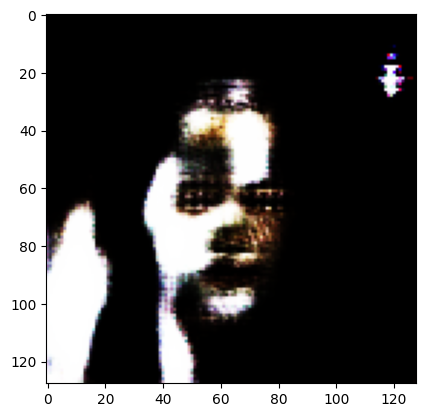

In [49]:
generator = tf.keras.models.load_model(os.path.join(os.environ['CHECKPOINT_PATH'], 'generator_epoch_1320.h5'))
noise = np.random.normal(0, 1, (1, 250))
gen_imgs = generator.predict(noise)
gen_imgs = 0.5 * gen_imgs + 0.5
plt.imshow(gen_imgs[0])